In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d akash2sharma/tiny-imagenet

 98% 467M/474M [00:06<00:00, 105MB/s] 
100% 474M/474M [00:06<00:00, 78.0MB/s]


In [ ]:
!unzip /content/tiny-imagenet.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_5500.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5501.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5502.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5503.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5504.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5505.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5506.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5507.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5508.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5509.JPEG  
  inflating: tiny-imagenet-200/val/images/val_551.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5510.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5511.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5512.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5513.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5514.JPEG  
  inflating: tiny-imag

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2

In [ ]:
Resnet = ResNet50V2(include_top=False, weights=None,
    input_shape=(256,256,3),
    pooling=None)

In [ ]:
Resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential

layer_name = 'conv4_block6_out'
layer_output = Resnet.get_layer(name = layer_name).output
intermediate_model=tf.keras.models.Model(inputs=Resnet.input,outputs=layer_output)
backbone = Sequential()
backbone.add(intermediate_model)

In [ ]:
backbone.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8, 8, 1024)        8573440   
Total params: 8,573,440
Trainable params: 8,548,480
Non-trainable params: 24,960
_________________________________________________________________


In [ ]:
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, ReLU, add, Flatten, Activation

def upsample(filters, size, stride, shape, apply_dropout = False, last_layer=False):

    initializer = tf.random_normal_initializer(0.,0.02)

    result = Sequential()

    result.add(Conv2DTranspose(filters,size,strides=stride,padding='same',batch_input_shape=shape,kernel_initializer=initializer, use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:

        result.add(Dropout(0.5))

    if last_layer:
      result.add(Activation('tanh'))
      print("yay last layer")
    else:
      result.add(ReLU())

    return result

In [ ]:
head1 = Sequential()

head1.add(backbone)
head1.add(upsample(256,4,1,(None,8,8,1024),apply_dropout=True))
head1.add(upsample(128,4,2,(None,8,8,256),apply_dropout=True))
head1.add(upsample(64,4,1,(None,16,16,128)))
head1.add(upsample(32,4,2,(None,16,16,64)))
head1.add(upsample(1,4,1,(None,32,32,32),last_layer=True))
head1.add(Flatten())

yay last layer


In [ ]:
head2 = Sequential()

head2.add(backbone)
head2.add(upsample(256,4,1,(None,8,8,1024),apply_dropout=True))
head2.add(upsample(128,4,2,(None,8,8,256),apply_dropout=True))
head2.add(upsample(64,4,1,(None,16,16,128)))
head2.add(upsample(32,4,2,(None,16,16,64)))
head2.add(upsample(1,4,1,(None,32,32,32), last_layer=True))
head2.add(Flatten())

yay last layer


In [ ]:
head1.load_weights('/content/drive/MyDrive/SSL_small/head1_51.h5')
head2.load_weights('/content/drive/MyDrive/SSL_small/head2_51.h5')

In [ ]:
import shutil

shutil.rmtree('/content/tiny-imagenet-200/tiny-imagenet-200')

In [ ]:
batch_size = 8
img_height = 256
img_width = 256
data_dir = '/content/tiny-imagenet-200/train'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.0,
  shuffle = True, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100000 files belonging to 200 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684'

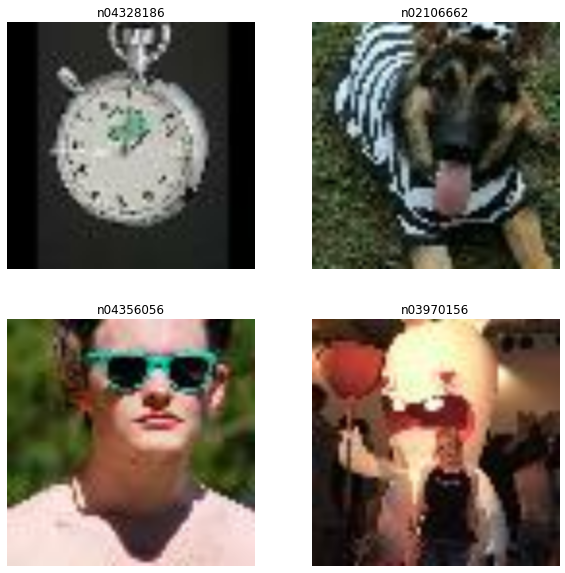

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
import keras
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
num_classes = 200
num_features = 2048

W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
b = tf.Variable(tf.zeros([num_classes]), name="bias")

In [ ]:
def logistic_regression(x):

    # Apply softmax to normalize the logits to a probability distribution.

    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.

def cross_entropy(y_pred, y_true):

    # Encode label to a one hot vector.

    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [ ]:
learning_rate = 0.001

training_steps = 1000

In [ ]:
def accuracy(y_pred, y_true):

# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.

optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
def run_optimization(x, y):

# Wrap computation inside a GradientTape for automatic differentiation.

    with tf.GradientTape() as g:

        pred = logistic_regression(x)

        loss = cross_entropy(pred, y)

    # Compute gradients.

    gradients = g.gradient(loss, [W, b])

    # Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients, [W, b]))

In [ ]:
display_step =  500
total_steps = 25000

In [ ]:
import pickle

epochs = 10

for epoch in range(epochs):

  for step, (batch_x, batch_y) in enumerate(normalized_ds, 1):

      rep1 = head1(batch_x, training = False)
      rep2 = head2(batch_x, training = False)

      batch_x = tf.concat([rep1, rep2], axis=1)
      
      rep1 = None
      rep2 = None

      run_optimization(batch_x, batch_y)
      
      if step % display_step == 0:

          pred = logistic_regression(batch_x)

          loss = cross_entropy(pred, batch_y)

          acc = accuracy(pred, batch_y)

          print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

          pred = None
          loss = None
          acc = None
          batch_x = None
          batch_y = None

      else:

        batch_x = None
        batch_y = None

  with open('lr_w.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(W, file)
    
  with open('lr_b.pkl', 'wb') as file:
    pickle.dump(b,file)

  print('Epoch {} done'.format(epoch))

step: 500, loss: 35.931759, accuracy: 0.125000
step: 1000, loss: 32.216209, accuracy: 0.250000
step: 1500, loss: 34.318447, accuracy: 0.125000
step: 2000, loss: 36.146927, accuracy: 0.000000
step: 2500, loss: 32.503571, accuracy: 0.250000
step: 3000, loss: 36.060616, accuracy: 0.125000
step: 3500, loss: 35.599503, accuracy: 0.125000
step: 4000, loss: 35.273308, accuracy: 0.125000
step: 4500, loss: 37.112602, accuracy: 0.125000
step: 5000, loss: 34.500828, accuracy: 0.000000
step: 5500, loss: 34.600677, accuracy: 0.125000
step: 6000, loss: 28.928043, accuracy: 0.250000
step: 6500, loss: 34.514202, accuracy: 0.125000
step: 7000, loss: 31.581604, accuracy: 0.125000
step: 7500, loss: 32.118580, accuracy: 0.000000
step: 8000, loss: 33.658413, accuracy: 0.000000
step: 8500, loss: 35.774757, accuracy: 0.000000
step: 9000, loss: 34.168415, accuracy: 0.125000
step: 9500, loss: 35.892731, accuracy: 0.125000
step: 10000, loss: 31.856916, accuracy: 0.000000
step: 10500, loss: 29.701674, accuracy: 